# ITT 2023 LNLS: Compresed Sensing (CS) Challenge
## CS applied to FTIR at LNLS IMBUIA Beamline 

In [44]:
import numpy as np 
import pandas 
import matplotlib.pyplot as plt
from scipy.optimize import minimize as scipy_minimize
import random
from scipy.optimize import linprog

random.seed(42)

# Read IMBUIA data

### Air interferogram and Spectrum computed by FTIR software

In [45]:
# Escrever um string com o caminho para o dado na pasta do google drive
path = 'data/'

# Name .csv file
name_espectrum_air = 'ar_ATR_spectrum.csv'
name_interferogram_air = 'ar_atr_interf.csv'

data_air_spectrum = pandas.read_csv(path+name_espectrum_air, header=None)
data_air_spectrum = np.asarray(data_air_spectrum)

data_air_interf = pandas.read_csv(path+name_interferogram_air, header=None)
data_air_interf = np.asarray(data_air_interf)

transmission_air = np.exp(-data_air_spectrum[:,1])

# All the data is written as follows:
#
#
# n_points: number of acquired points
# interferogram.shape = (n_points_interf, 4)
# interferogram: column 0 - x-direction - Optical path [cm]
# interferogram: column 1 - y-direction - Voltz [V]
# ---------------------------------------------------
# spectrum.shape = (n_points_spectrum, 2)
# spectrum: column 0 - x-direction - Frequency [1/cm]
# spectrum: column 1 - y-direction - Absorption

### Plot interferogram and spectrum

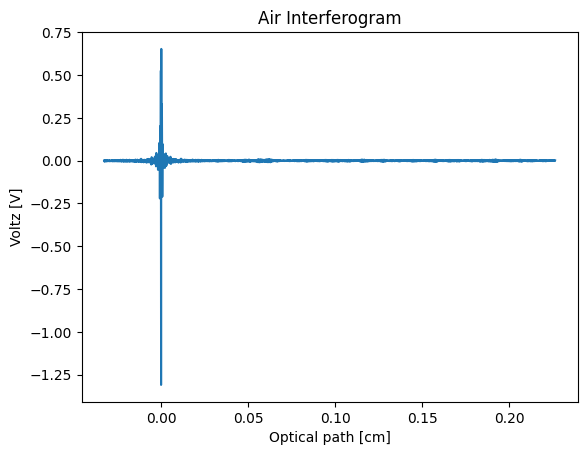

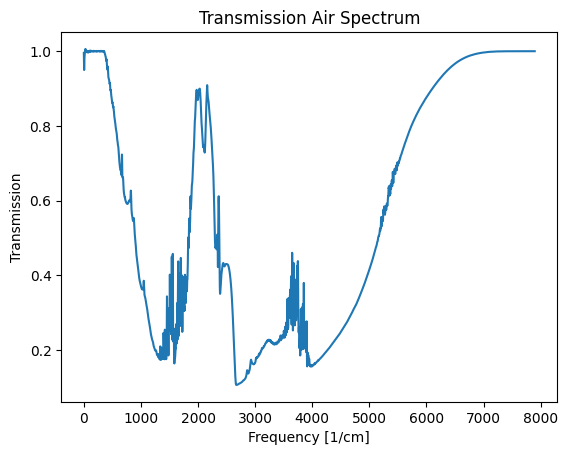

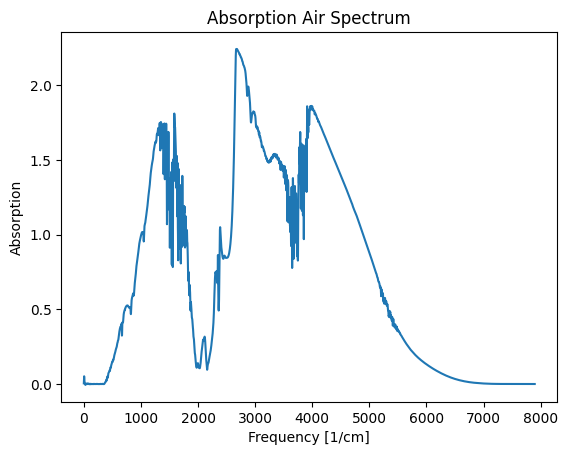

In [46]:
plt.figure(0)
plt.plot(data_air_interf[:,0],data_air_interf[:,1])
plt.xlabel('Optical path [cm]')
plt.ylabel('Voltz [V]')
plt.title('Air Interferogram')

plt.figure(1)
plt.plot(data_air_spectrum[:,0],transmission_air)
plt.xlabel('Frequency [1/cm]')
plt.ylabel('Transmission')
plt.title('Transmission Air Spectrum')

plt.figure(2)
plt.plot(data_air_spectrum[:,0],data_air_spectrum[:,1])
plt.xlabel('Frequency [1/cm]')
plt.ylabel('Absorption')
plt.title('Absorption Air Spectrum')

plt.show()

### Simulated Problem

Distance between simulated interferogram and inverse exact Fourier transform is 0.783872514976089


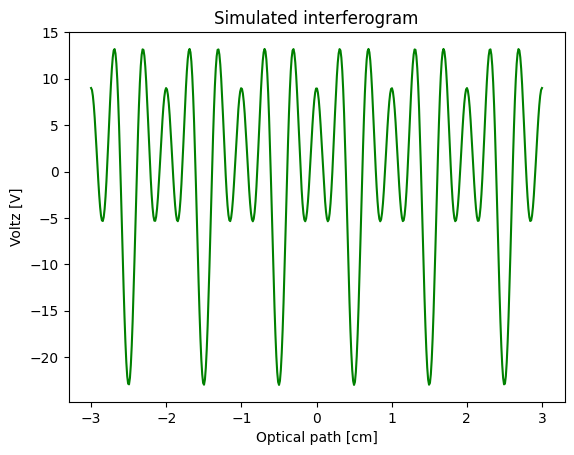

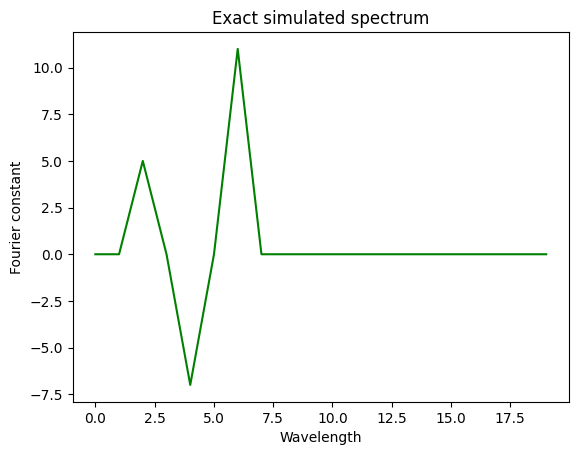

In [47]:
cut=20
percent  = 0.05
n        = 1000
m        = int(n*percent)
n_smooth = 500 # Number of points to plot smooth interferograms (not related to n)

# Set spectrum :
hz_range            = np.linspace(0, 1000, n) # The range is from physics (what should be expected for the experiment)
# n depends on the resolution of the wave spectrum

# -3 to 3 chosen for better plots because normal distribution rarely exceeds
t_smooth              = np.linspace(-3, 3, n_smooth)
interferogram_smooth  = 5*np.cos(2*np.pi*t_smooth) - 7*np.cos(4*np.pi*t_smooth) + 11*np.cos(6*np.pi*t_smooth)

# DFT Complex matrix
DFT_smooth = [[np.cos(np.pi*hz_range[j]*t_smooth[i]) for j in range(n)] for i in range(n_smooth)]

# Exact spectrum from Euler's formula for cosines
exact_spectrum      = np.zeros(n)
exact_spectrum[2] = 5
exact_spectrum[4] = -7
exact_spectrum[6] = 11

# Get interferogram to check
interferogram_from_exact = np.dot(DFT_smooth, exact_spectrum).real
print("Distance between simulated interferogram and inverse exact Fourier transform is", np.linalg.norm(interferogram_smooth-interferogram_from_exact, np.inf))

# Plot
plt.figure(3)
plt.plot(t_smooth, interferogram_smooth, 'g')
plt.xlabel('Optical path [cm]')
plt.ylabel('Voltz [V]')
plt.title('Simulated interferogram')

plt.figure(4)
plt.plot(hz_range[:cut], exact_spectrum[:cut], 'g')
plt.xlabel('Wavelength')
plt.ylabel('Fourier constant')
plt.title('Exact simulated spectrum')

plt.show()


## Select samples from interferogram

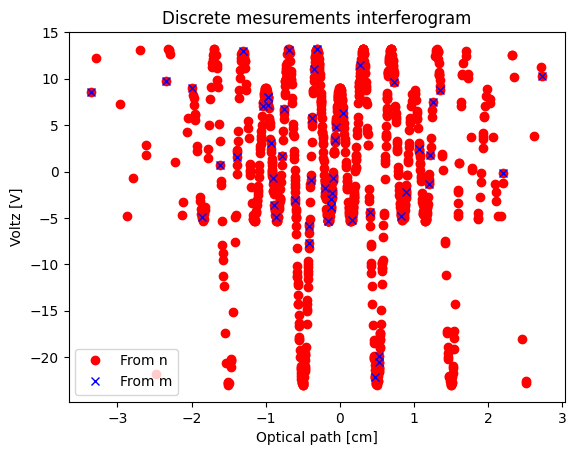

In [48]:
# n random samples normally distributed
t_sample_n             = np.random.normal(size=n)
interferogram_sample_n = 5*np.cos(2*np.pi*t_sample_n) - 7*np.cos(4*np.pi*t_sample_n) + 11*np.cos(6*np.pi*t_sample_n)
DFT_n                  = [[np.exp(-np.pi*hz_range[j]*t_sample_n[i]*1j) for j in range(n)] for i in range(n)]

# Choose m random samples from the previous n
rows_id                = np.random.choice(n, size=m, replace=False)
t_sample_m             = t_sample_n[rows_id]
interferogram_sample_m = interferogram_sample_n[rows_id]
DFT_m                  = [DFT_n[i] for i in rows_id]

plt.figure(5)
plt.plot(t_sample_n, interferogram_sample_n, 'ro', label="From n")
plt.plot(t_sample_m, interferogram_sample_m, 'bx', label="From m")
plt.xlabel('Optical path [cm]')
plt.ylabel('Voltz [V]')
plt.title('Discrete mesurements interferogram')
plt.legend()

plt.show()

## Spectogram from n datapoints (the stupid way)

c:\Users\gggt4\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


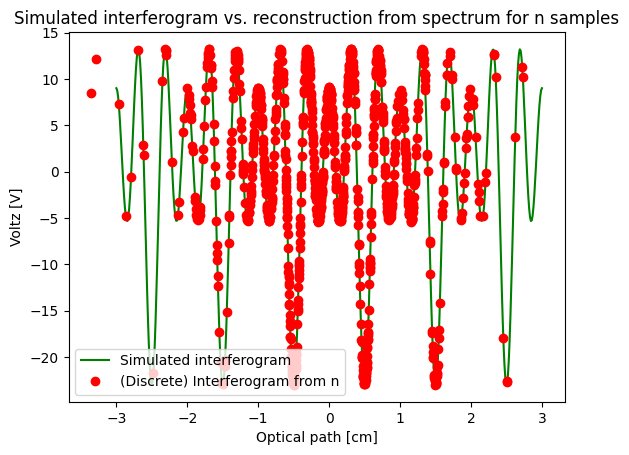

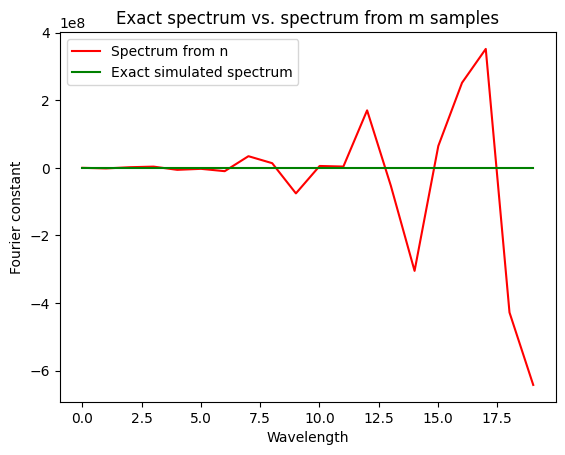

In [49]:
spectrum_n = np.linalg.solve(DFT_n, interferogram_sample_n)

# Computed simulated solutions
interferogram_n = np.dot(DFT_n, spectrum_n)

# Plot
plt.figure(6)
plt.plot(t_smooth, interferogram_smooth, color='g', label="Simulated interferogram")
plt.plot(t_sample_n, interferogram_n, 'ro', label="(Discrete) Interferogram from n")
plt.xlabel('Optical path [cm]')
plt.ylabel('Voltz [V]')
plt.title('Simulated interferogram vs. reconstruction from spectrum for n samples')
plt.legend()

plt.figure(7)
plt.plot(hz_range[:cut], spectrum_n[:cut], 'r', label="Spectrum from n")
plt.plot(hz_range[:cut], exact_spectrum[:cut], 'g', label="Exact simulated spectrum")
plt.xlabel('Wavelength')
plt.ylabel('Fourier constant')
plt.title('Exact spectrum vs. spectrum from m samples')
plt.legend()

plt.show()

### Initial example solving the CS problem by linear programming

In [50]:
def get_s(A, y):
    # Initial example of linear programming function to solve the Compressed sensing problem for FTIR

    A=np.array(A)
    Aeq=np.concatenate((A,-A), axis=1)

    x_dim = Aeq.shape[1]

    obj = np.ones(x_dim)

    bnd = [*((0, None) for _ in range(x_dim))]

    res = linprog(c=obj, A_eq=Aeq, b_eq=y, bounds = bnd, method="revised simplex")

    return res.x[:x_dim//2]-res.x[x_dim//2:]


c:\Users\gggt4\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linprog_util.py:166: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.array(A, dtype=float, copy=True)
C:\Users\gggt4\AppData\Local\Temp\ipykernel_5616\3146713644.py:13: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  res = linprog(c=obj, A_eq=Aeq, b_eq=y, bounds = bnd, method="revised simplex")


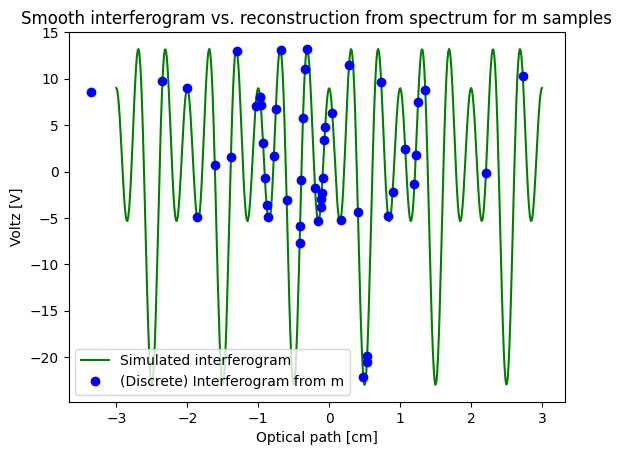

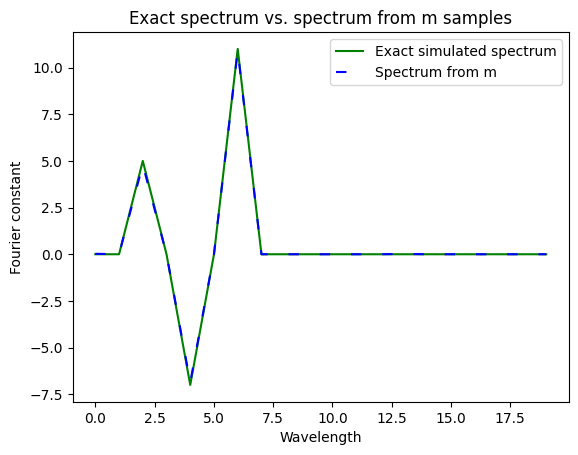

In [51]:
spectrum_m = get_s(DFT_m, interferogram_sample_m)

# Computed simulated solutions
interferogram_m = np.dot(DFT_m, spectrum_m)

# Plot
plt.figure(8)
plt.plot(t_smooth, interferogram_smooth, color='g', label="Simulated interferogram")
plt.plot(t_sample_m, interferogram_m, 'bo', label="(Discrete) Interferogram from m")
plt.xlabel('Optical path [cm]')
plt.ylabel('Voltz [V]')
plt.title('Smooth interferogram vs. reconstruction from spectrum for m samples')
plt.legend()

plt.figure(9)
plt.plot(hz_range[:cut], exact_spectrum[:cut], 'g', label="Exact simulated spectrum")
plt.plot(hz_range[:cut], spectrum_m[:cut], linestyle=(0,(5,10)), color='b', label="Spectrum from m")
plt.xlabel('Wavelength')
plt.ylabel('Fourier constant')
plt.title('Exact spectrum vs. spectrum from m samples')
plt.legend()

plt.show()

### Plot and compare solutions

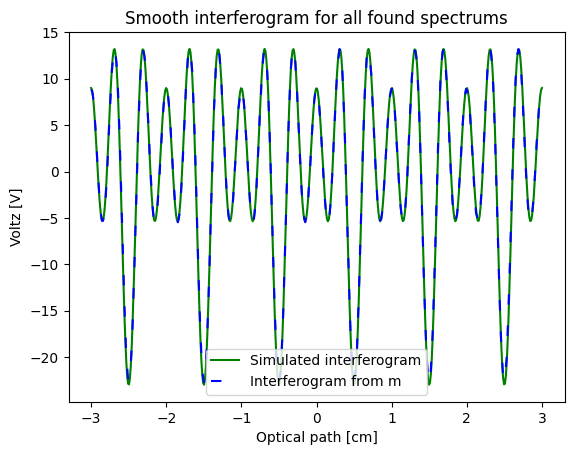

In [54]:
# Provided solutions
def f_interferogram(spectrum, t_space):
    sol=[]

    for x in t_space:
        sum=0
        
        for i in range(len(hz_range)): 
            sum+=spectrum[i]*np.cos(np.pi*hz_range[i]*x)

        sol.append(sum)

    return sol

# Plots
plt.figure(10)
plt.plot(t_smooth, interferogram_smooth, 'g', label="Simulated interferogram")
#plt.plot(t_smooth, f_interferogram(spectrum_n, t_smooth), linestyle=(0,(5,10)), color='r', label="Interferogram from n")
plt.plot(t_smooth, f_interferogram(spectrum_m, t_smooth), linestyle=(0,(5,10)), color='b', label="Interferogram from m")
plt.xlabel('Optical path [cm]')
plt.ylabel('Voltz [V]')
plt.title('Smooth interferogram for all found spectrums')
plt.legend()

plt.show()

In [53]:
DFT_smooth=np.array(DFT_smooth)

print(np.matmul(DFT_smooth.T, DFT_smooth))

[[ 5.00000000e+02 -1.49888864e+00  1.49855456e+00 ...  4.99970214e+02
  -5.00022252e-01  1.00000000e+00]
 [-1.49888864e+00  2.50749277e+02 -1.49844320e+00 ... -1.49662779e+00
   2.50485107e+02 -8.33120648e-01]
 [ 1.49855456e+00 -1.49844320e+00  2.50748609e+02 ...  1.49778919e+00
  -1.82972619e+00  2.50609585e+02]
 ...
 [ 4.99970214e+02 -1.49662779e+00  1.49778919e+00 ...  4.99940430e+02
  -4.97927193e-01  9.99321788e-01]
 [-5.00022252e-01  2.50485107e+02 -1.82972619e+00 ... -4.97927193e-01
   2.50250045e+02 -1.16623468e+00]
 [ 1.00000000e+00 -8.33120648e-01  2.50609585e+02 ...  9.99321788e-01
  -1.16623468e+00  2.50500000e+02]]
